## Кривоногов Н.В., INN, практическое задание № 5

1. Попробуйте изменить параметры нейронной сети, работающей с датасетом imdb, либо нейронной сети, работающей airline-passengers (она прилагается вместе с датасетом к уроку в виде отдельного скрипта) так, чтобы улучшить её точность. Приложите анализ
2. Попробуйте изменить параметры нейронной сети, генерирующей текст таким образом, чтобы добиться генерации как можно более осмысленного текста. Пришлите лучший текст из получившихся и опишите предпринятые для его получения действия. Можно использовать текст другого произведения
3. *Попробуйте реализовать нейронную сеть архитектуры LSTM на numpy
4. *Предложите свои варианты решения проблемы исчезающего градиента в RNN

### IMDB

In [40]:
import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from tensorflow.keras.optimizers import Adam, Nadam
from keras.layers import LSTM
from keras.datasets import imdb
from keras.utils import pad_sequences

max_features = 10000

# обрезаем тексты после данного количества слов (среди top max_features наиболее используемые слова)
maxlen = 80
batch_size = 128 # увеличьте значение для ускорения обучения
num_epochs = 3

print('Загрузка данных...')
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)
print(len(X_train), ' - тренировочные последовательности')
print(len(X_test), ' - тестовые последовательности')

print('Pad последовательности (примеров в x единицу времени)')
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

print('Построение модели...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(Dropout(0.3))
model.add(LSTM(128, dropout=0.2))
model.add(Dense(1, activation='tanh'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

print('Процесс обучения...')
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          validation_data=(X_test, y_test))

print('Валидация модели')
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print('Точность на тесте: ', acc)

Загрузка данных...
25000  - тренировочные последовательности
25000  - тестовые последовательности
Pad последовательности (примеров в x единицу времени)
X_train shape: (25000, 80)
X_test shape: (25000, 80)
Построение модели...
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, None, 128)         1280000   
                                                                 
 dropout_21 (Dropout)        (None, None, 128)         0         
                                                                 
 lstm_23 (LSTM)              (None, 128)               131584    
                                                                 
 dense_22 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,411,713
Trainable params: 1,411,713
Non-trainable params: 0
_______________

1. Первоначальная точность: 0.8348
2. max_features = 18200, точность: 0.8262
3. optimizer='Nadam', точность: 0.8359 - улучшение
4. maxlen = 70, точность: 0.8286
5. batch_size = 256, точность: 0.8358 - улучшение
6. max_features = 8888, точность: 0.8309
7. num_epochs = 2, точность: 0.8424 - улучшение
8. model.add(LSTM(128, dropout=0.15)), точность: 0.8364 - улучшение
9. model.add(LSTM(256, dropout=0.2)), точность: 0.8360 - улучшение
10. model.add(Dense(1, activation='tanh')), точность: 0.8329

Можно сделать вывод: рекуррентные нейронные сети обладают большим количеством гибких параметров, настройка которых может сильно повлиять на точность модели. 

### Для задачи генерации текста попробую использовать произведение Джорджа Оруэлла "1984"

In [15]:
# импорт библиотек: 

import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

In [ ]:
!wget https://drive.google.com/file/d/1YDrWAhIwPrt9bvv8oNb8rR8cuPFkGXsB/view?usp=sharing -O 1984.txt

In [1]:
# читаю текст: 

data = open('1984.txt', encoding='utf-8').read()
corpus = data.lower().split("\n")
corpus[:10]

['1984. george orwell',
 '',
 'part i',
 '',
 '',
 'i',
 '',
 '',
 'it was a bright cold day in april, and the clocks were striking thirteen. winston smith, his chin nuzzled into his breast in an effort to escape the vile wind, slipped quickly through the glass doors of victory mansions, though not quickly enough to prevent a swirl of gritty dust from entering along with him.',
 '']

In [ ]:
# # ДЛЯ ЗАПУСКА ИЗ jupyter notebook: 
# # читаю текст: 

# data = open('1984.txt', encoding='utf-8').read()
# corpus = data.lower().split("\n")
# corpus[:10]

In [3]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


# создаю объект для токенизации: 
total_words = 1000
tokenizer = Tokenizer(num_words=total_words)
tokenizer.fit_on_texts(corpus)

# tokenizer.index_word

In [4]:
print(corpus[0])
print(tokenizer.texts_to_sequences([corpus[0]]))
print(tokenizer.word_index['1984'], tokenizer.word_index['george'])

1984. george orwell
[[375]]
375 2347


In [5]:
# создаю последовательность токенов: 

input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		sequence = token_list[:i+1]
		input_sequences.append(sequence)
input_sequences[:10]

[[376, 79],
 [9, 3],
 [9, 3, 4],
 [9, 3, 4, 497],
 [9, 3, 4, 497, 343],
 [9, 3, 4, 497, 343, 110],
 [9, 3, 4, 497, 343, 110, 7],
 [9, 3, 4, 497, 343, 110, 7, 747],
 [9, 3, 4, 497, 343, 110, 7, 747, 5],
 [9, 3, 4, 497, 343, 110, 7, 747, 5, 1]]

In [6]:
# pad sequences: 

max_sequence_len = max([len(x) for x in input_sequences])
print(max_sequence_len)
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences[:10]

395


array([[  0,   0,   0, ...,   0, 376,  79],
       [  0,   0,   0, ...,   0,   9,   3],
       [  0,   0,   0, ...,   9,   3,   4],
       ...,
       [  0,   0,   0, ..., 110,   7, 747],
       [  0,   0,   0, ...,   7, 747,   5],
       [  0,   0,   0, ..., 747,   5,   1]], dtype=int32)

In [7]:
predictors, label = input_sequences[:,:-1], input_sequences[:,-1]

label = to_categorical(label, num_classes=total_words)
label.shape

(21469, 1000)

In [8]:
predictors[0], np.argmax(label[0])

(array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0

СОЗДАЮ СЕТЬ: 

In [9]:
from keras.layers import Dropout, Bidirectional
from keras import regularizers
from tensorflow.keras.optimizers import Adam


early_stop = EarlyStopping(monitor='val_loss', patience=10)

model = Sequential()
model.add(Embedding(input_dim=total_words,
                    output_dim=512,
                    input_length=max_sequence_len-1))

model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Bidirectional(LSTM(512, return_sequences=True)))
model.add(LSTM(1024))
model.add(Dropout(0.2))
model.add(Dense(total_words * 2 , activation='relu'))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 394, 512)          512000    
                                                                 
 bidirectional (Bidirectiona  (None, 394, 512)         1574912   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 394, 1024)        4198400   
 nal)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 1024)              8392704   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 2000)              2

In [10]:
# к сожалению обучение длится очень долго, что не дает возможности вдоволь поэкспериментировать с параметрами нейронной сети: 

history = model.fit(predictors, label,
                    epochs=100,
                    validation_split=0.2,
                    callbacks=[early_stop],
                    verbose=1)

Epoch 1/100
537/537 [==============================] - 319s 564ms/step - loss: 5.6381 - accuracy: 0.0788 - val_loss: 5.5496 - val_accuracy: 0.0796
Epoch 2/100
537/537 [==============================] - 268s 500ms/step - loss: 5.3260 - accuracy: 0.1056 - val_loss: 5.4562 - val_accuracy: 0.0994
Epoch 3/100
537/537 [==============================] - 265s 493ms/step - loss: 5.1224 - accuracy: 0.1248 - val_loss: 5.3566 - val_accuracy: 0.1106
Epoch 4/100
537/537 [==============================] - 263s 489ms/step - loss: 4.9514 - accuracy: 0.1368 - val_loss: 5.2855 - val_accuracy: 0.1232
Epoch 5/100
537/537 [==============================] - 266s 496ms/step - loss: 4.8124 - accuracy: 0.1447 - val_loss: 5.2397 - val_accuracy: 0.1330
Epoch 6/100
537/537 [==============================] - 245s 456ms/step - loss: 4.6858 - accuracy: 0.1503 - val_loss: 5.2982 - val_accuracy: 0.1262
Epoch 7/100
537/537 [==============================] - 265s 494ms/step - loss: 4.5535 - accuracy: 0.1563 - val_loss: 5

ТЕСТ:

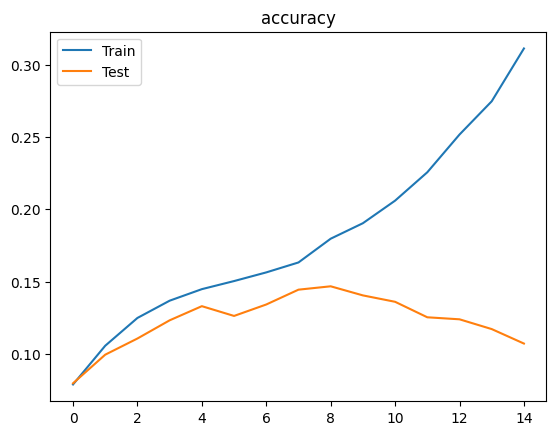

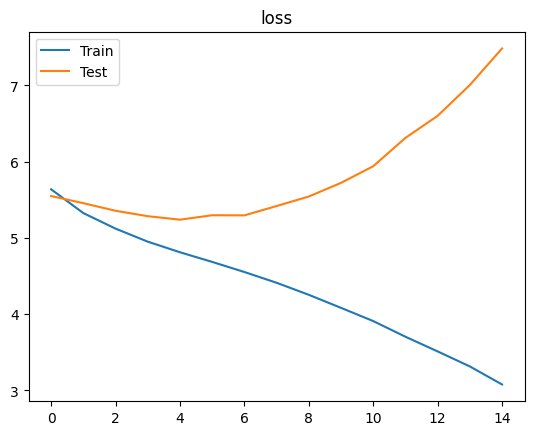

In [16]:
acc = history.history['accuracy']
acc_v = history.history['val_accuracy']
loss = history.history['loss']
loss_v = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Train')
plt.plot(epochs, acc_v, label='Test')
plt.legend()
plt.title('accuracy')

plt.figure()

plt.plot(epochs, loss, label='Train')
plt.plot(epochs, loss_v, label='Test')
plt.title('loss')
plt.legend()

plt.show()

СТРОЮ ТЕСТЫ ГЕНЕРАТОРА: 

In [18]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"

next_words = 10
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    print(token_list)
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted_proba = model.predict(token_list, verbose=0)
    predicted_classes = np.argmax(predicted_proba, axis=1)

    output_word = tokenizer.index_word[predicted_classes[0]]
    seed_text += " " + output_word
    
print(seed_text)

[309, 928, 65, 664]
[309, 928, 65, 664, 6]
[309, 928, 65, 664, 6, 29]
[309, 928, 65, 664, 6, 29, 166]
[309, 928, 65, 664, 6, 29, 166, 200]
[309, 928, 65, 664, 6, 29, 166, 200, 26]
[309, 928, 65, 664, 6, 29, 166, 200, 26, 33]
[309, 928, 65, 664, 6, 29, 166, 200, 26, 33, 16]
[309, 928, 65, 664, 6, 29, 166, 200, 26, 33, 16, 183]
[309, 928, 65, 664, 6, 29, 166, 200, 26, 33, 16, 183, 1]
Help me Obi Wan Kenobi, you're my only hope to him whether possible winston could not remember the of


Помоги мне, Оби Ван Кеноби, ты моя единственная надежда

на него, возможно ли, что Уинстон не смог вспомнить о

In [19]:
seed_text = "Russia must move forward, relying on the best traditions"

next_words = 10
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    print(token_list)
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted_proba = model.predict(token_list, verbose=0)
    predicted_classes = np.argmax(predicted_proba, axis=1)

    output_word = tokenizer.index_word[predicted_classes[0]]
    seed_text += " " + output_word
    
print(seed_text)

[141, 853, 20, 1, 980]
[141, 853, 20, 1, 980, 2]
[141, 853, 20, 1, 980, 2, 814]
[141, 853, 20, 1, 980, 2, 814, 3]
[141, 853, 20, 1, 980, 2, 814, 3, 1]
[141, 853, 20, 1, 980, 2, 814, 3, 1, 2]
[141, 853, 20, 1, 980, 2, 814, 3, 1, 2, 4]
[141, 853, 20, 1, 980, 2, 814, 3, 1, 2, 4, 2]
[141, 853, 20, 1, 980, 2, 814, 3, 1, 2, 4, 2, 701]
[141, 853, 20, 1, 980, 2, 814, 3, 1, 2, 4, 2, 701, 882]
Russia must move forward, relying on the best traditions of holes was the of a of shorts grey and


Россия должна идти вперед, опираясь на лучшие традиции 

дырок были в шортах серого цвета и